# Fast AI Tabular: Regression
Fast AI is a deep learning library built on top of PyTorch, designed to make it easier and faster to develop and train deep learning models.

In this section I used FastAI to implement regression on a tabular dataset where the 'X' features are buisiness Key Performance Indicators and the 'y' target Total Environmental Intensity (Revenue) is an estimate of the Total Environmental Cost divided by Revenue for that company.

## Imports

In [2]:
import pandas as pd
import numpy as np
# importing libraries for use with fast-ai
# -- uncomment if using within google colab env --
#import fastbook 
#fastbook.setup_book()
#from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
import sklearn
from IPython.display import Image, display_svg, SVG


## The Data

In [284]:
corp_env_impact_3pct = pd.read_csv('../../data/tabular_data/final_raw_sample_3_percent.csv')

There are two datasets. Each one has its' own unique rows based on the application of uncertainty estimates of 0 and 3 percent in the calculations of environmental cost. They both have similar column features. According to the data source, these features are the impact of buisnesses on eight "safeguard subjects":
1. Human Health (Working Capacity): Working Capacity captures human health effects from climate change, air pollution, and toxicity.
2. Crop Production : captures soil degradation, air pollution, climate change, and land use.
3. Meat Production Capacity: includes soil degradation, climate change, land use, and toxicity.
4. Fish Production Capacity: includes acidification, eutrophication, climate change, and toxicity.
5. Wood Production Capacity: includes climate change, air pollution, and land use.
6. Drinking Water & Irrigation Water (Water Production Capacity): captures climate change, land use, and water pollution.
7. Abiotic Resources: includes environmental impacts from mining.
8. Biodiversity: captures land use and toxicity.

The dataset also includes further uncertainty estimates that may increase the accuracy of the model, but for the purposes of this assignment, we will stick to these eight. I will also be using the data that includes uncertainty estimates (3 percent discount rate).

In [285]:
corp_env_impact_3pct.head()

,Year,Company Name,Country,Industry (Exiobase),Total Environmental Intensity (Revenue),Total Environmental Intensity (Operating Income),Total Environmental Cost,Working Capacity,Fish Production Capacity,Crop Production Capacity,Meat Production Capacity,Biodiversity,Abiotic Resources,Water production capacity (Drinking water & Irrigation Water),Wood Production Capacity,% Imputed
0,2018,APPLUS SERVICES SA,Spain,Activities auxiliary to financial intermediation (67),-1.62%,-25.12%,"(3,10,59,488)","(69,39,394)","(1,763)","(90,516)","(21,094)",(310),"(3,850)","(2,40,03,212)",652,0%
1,2018,TELEPERFORMANCE SE,France,Activities auxiliary to financial intermediation (67),-0.46%,-4.28%,"(2,35,30,704)","(1,75,76,865)","(4,191)","(2,34,020)","(54,603)",(766),"(3,661)","(56,57,645)","1,047",1%
2,2018,SGS SA,Switzerland,Activities auxiliary to financial intermediation (67),-0.32%,-2.13%,"(2,20,83,908)","(1,83,85,456)","(4,273)","(2,43,627)","(56,860)",(783),"(3,489)","(33,90,060)",639,0
3,2018,INTERTEK GROUP PLC,United Kingdom,Activities auxiliary to financial intermediation (67),-0.55%,-3.39%,"(1,97,43,336)","(1,93,12,582)","(4,522)","(2,56,694)","(60,089)",(820),"(3,428)","(1,05,662)",461,1%
4,2018,THOMSON REUTERS CORP,Canada,Activities auxiliary to financial intermediation (67),-0.26%,-1.91%,"(1,42,55,905)","(91,62,390)","(3,149)","(1,26,821)","(28,623)",(597),"(1,94,781)","(47,45,756)","6,212",18%


In [286]:
corp_env_impact_3pct.shape

(13177, 16)

# Pre-processing

 It is mentioned in the kaggle source that "Each safeguard subject is made up of multiple impact categories and indicators, called state indicators, for measuring the current state of each safeguard subject (Life Cycle Initiative 2016; Steen and Palander 2016)."

Guidance given in the Kaggle source:

'y' target:

- Total Environmental Intensity (Revenue): The monetized environmental impact of the firm's operations during the specific year indicated in column A divided by revenue in that year.

'X' features: 

- Column H: Working Capacity captures human health effects from climate change, air pollution, and toxicity.
- Column I: Fish Production Capacity includes acidification, eutrophication, climate change, and toxicity.
- Column J: Crop Production Capacity captures soil degradation, air pollution, climate change, and land use.
- Column K: Meat Production Capacity includes soil degradation, climate change, land use, and toxicity.
- Column L: Biodiversity captures land use and toxicity.
- Column M: Abiotic Resources includes environmental impacts from mining.
- Column N: Water production capacity captures climate change, land use, and water pollution.
- Column O: Wood Production Capacity includes climate change, air pollution, and land use.
- Company Name

The data was further pre-processed in the HuggingFace tabular question answering model. In this notebook, we will test whether the split columns increase the signal of safeguard subject features and enhance the ability of the regression model to estimate environmental cost by revenue.




## Cleaning safeguard subjects (combining the tuple elements into a single feature)

In [287]:
def clean_numeric_text(df, column_name):
    print(column_name)
    # Remove parentheses and commas
    df[column_name] = df[column_name].str.replace(r'[\(\),]', '', regex=True)
    # Convert to integer data type
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce', downcast='integer')

In [288]:
env_features = corp_env_impact_3pct.iloc[:, 7: 15]

In [289]:
env_features['Year'] = corp_env_impact_3pct.Year
env_features['target'] = corp_env_impact_3pct['Total Environmental Intensity (Operating Income)']

In [290]:
env_features.head()

,Working Capacity,Fish Production Capacity,Crop Production Capacity,Meat Production Capacity,Biodiversity,Abiotic Resources,Water production capacity (Drinking water & Irrigation Water),Wood Production Capacity,Year,target
0,"(69,39,394)","(1,763)","(90,516)","(21,094)",(310),"(3,850)","(2,40,03,212)",652,2018,-25.12%
1,"(1,75,76,865)","(4,191)","(2,34,020)","(54,603)",(766),"(3,661)","(56,57,645)","1,047",2018,-4.28%
2,"(1,83,85,456)","(4,273)","(2,43,627)","(56,860)",(783),"(3,489)","(33,90,060)",639,2018,-2.13%
3,"(1,93,12,582)","(4,522)","(2,56,694)","(60,089)",(820),"(3,428)","(1,05,662)",461,2018,-3.39%
4,"(91,62,390)","(3,149)","(1,26,821)","(28,623)",(597),"(1,94,781)","(47,45,756)","6,212",2018,-1.91%


In [291]:
# removing paranthesis and commas from columns 
for column in list(env_features.iloc[:, 0:8].columns):
    clean_numeric_text(env_features, column)


Working Capacity
Fish Production Capacity
Crop Production Capacity
Meat Production Capacity
Biodiversity
Abiotic Resources
Water production capacity (Drinking water & Irrigation Water)
Wood Production Capacity


In [292]:
def text_percent_to_numeric(text_percent):
    if isinstance(text_percent, type(np.nan)):
        return np.nan
    # Remove percentage sign and convert to float
    numeric_value = float(text_percent.strip('%'))
    # Convert to decimal representation
    numeric_value /= 100
    return numeric_value

In [293]:
env_features['target'] = env_features.target.apply(lambda x: text_percent_to_numeric(x))

In [294]:
env_features['Company Name'] = corp_env_impact_3pct['Company Name']

In [295]:
env_features.head()

,Working Capacity,Fish Production Capacity,Crop Production Capacity,Meat Production Capacity,Biodiversity,Abiotic Resources,Water production capacity (Drinking water & Irrigation Water),Wood Production Capacity,Year,target,Company Name
0,6939394,1763,90516,21094,310,3850.0,24003212,652.0,2018,-0.2512,APPLUS SERVICES SA
1,17576865,4191,234020,54603,766,3661.0,5657645,1047.0,2018,-0.0428,TELEPERFORMANCE SE
2,18385456,4273,243627,56860,783,3489.0,3390060,639.0,2018,-0.0213,SGS SA
3,19312582,4522,256694,60089,820,3428.0,105662,461.0,2018,-0.0339,INTERTEK GROUP PLC
4,9162390,3149,126821,28623,597,194781.0,4745756,6212.0,2018,-0.0191,THOMSON REUTERS CORP


## Cleaning safeguard subjects (splitting the tuple elements into multiple features)

In [296]:
# the data was preprocessed in the huggingface/tabular notebook and the data was saved in data/tabular_data
corp_safeguard_split = pd.read_csv('../../data/tabular_data/corp_safeguard_split.csv')

In [297]:
corp_safeguard_split.head()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,...,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,Year,Company Name,target
0,69,39,394.0,445.799955,1,763.0,90,516.0,437.036571,21,...,310,418.64977,3.0,850.0,2,40.0,3.0,2018,APPLUS SERVICES SA,-0.2512
1,1,75,76.0,865.000000,4,191.0,2,34.0,20.000000,54,...,766,418.64977,3.0,661.0,56,57.0,645.0,2018,TELEPERFORMANCE SE,-0.0428
2,1,83,85.0,456.000000,4,273.0,2,43.0,627.000000,56,...,783,418.64977,3.0,489.0,33,90.0,60.0,2018,SGS SA,-0.0213
3,1,93,12.0,582.000000,4,522.0,2,56.0,694.000000,60,...,820,418.64977,3.0,428.0,1,5.0,662.0,2018,INTERTEK GROUP PLC,-0.0339
4,91,62,390.0,445.799955,3,149.0,1,26.0,821.000000,28,...,597,418.64977,1.0,94.0,47,45.0,756.0,2018,THOMSON REUTERS CORP,-0.0191


## Processing with FastAI

In [298]:
print(corp_safeguard_split.shape)
print(env_features.shape)

(13177, 21)
(13177, 11)


In [299]:
env_features.Year.value_counts(normalize=True) # we will create a training condition using data before 2018

2017    0.135539
2018    0.134856
2016    0.131138
2015    0.122334
2014    0.113000
2013    0.105411
2012    0.096456
2011    0.084921
2010    0.076345
Name: Year, dtype: float64

In [300]:
year_cond = (env_features.Year<2018)
train_idx = np.where( year_cond)[0]
valid_idx = np.where(~year_cond)[0]
splits = (list(train_idx),list(valid_idx))

In [301]:
cont_names_env = list(env_features.columns)[:-1]
cont_names_env

['Working Capacity',
 'Fish Production Capacity',
 'Crop Production Capacity',
 'Meat Production Capacity',
 'Biodiversity',
 'Abiotic Resources',
 'Water production capacity (Drinking water & Irrigation Water)',
 'Wood Production Capacity',
 'Year',
 'target']

In [302]:
cat_names_env = list(env_features.columns)[-1]
cat_names_env

'Company Name'

In [303]:
env_features.target = env_features.target.fillna(env_features.target.mean())

In [304]:
# Instantiate a TabularPandas object with the FillMissing preprocessing step
procs_env = [Categorify, FillMissing, Normalize]
fastai_env_features = TabularDataLoaders.from_df(env_features, y_names="target",
    cont_names = cont_names_env,
    cat_names = cat_names_env,
    procs = procs_env)

In [305]:
cont_names_corp = list(corp_safeguard_split.columns[:-3])
cont_names_corp.append(corp_safeguard_split.columns[-1])
cont_names_corp

['working_capacity_0',
 'working_capacity_1',
 'working_capacity_2',
 'working_capacity_3',
 'fish_production_capacity_0',
 'fish_production_capacity_1',
 'crop_production_capacity_0',
 'crop_production_capacity_1',
 'crop_production_capacity_2',
 'meat_production_capacity_0',
 'meat_production_capacity_1',
 'biodiversity_0',
 'biodiversity_1',
 'abiotic_resources_0',
 'abiotic_resources_1',
 'water_production_capacity_(drinking_water_&_irrigation_water)_0',
 'water_production_capacity_(drinking_water_&_irrigation_water)_1',
 'water_production_capacity_(drinking_water_&_irrigation_water)_2',
 'target']

In [306]:
cat_names_corp = [corp_safeguard_split.columns[-2]]
cat_names_corp

['Company Name']

In [307]:
procs_corp = [Categorify, FillMissing, Normalize]

In [308]:
fastai_corpsplit_features = TabularDataLoaders.from_csv('../../data/tabular_data/corp_safeguard_split.csv', path='../../data/tabular_data/', y_names="target",
    cat_names = cat_names_corp,
    cont_names = cont_names_corp,
    procs = procs_corp)

In [309]:
print("Unsplit dataset shapes: Validation & Training")
print(fastai_env_features.valid_ds.items.shape, fastai_env_features.train_ds.items.shape)
print("Split dataset shapes: Validation & Training")
print(fastai_corpsplit_features.valid_ds.items.shape, fastai_corpsplit_features.train_ds.items.shape)

Unsplit dataset shapes: Validation & Training
(2635, 13) (10542, 13)
Split dataset shapes: Validation & Training
(2635, 22) (10542, 22)


# Training a Regression Model

In [310]:
from sklearn.ensemble import AdaBoostRegressor

In [311]:
# creating our train and test set
xs_env,y_env = fastai_env_features.train.xs,fastai_env_features.train.y
valid_xs_env,valid_y_env = fastai_env_features.valid.xs,fastai_env_features.valid.y

In [312]:
xs_corp, y_corp = fastai_corpsplit_features.train.xs, fastai_corpsplit_features.train.y
valid_xs_corp, valid_y_corp = fastai_corpsplit_features.valid.xs, fastai_corpsplit_features.valid.y

### Using Sklearn

In [313]:
regressor_model_env = AdaBoostRegressor()
regressor_model_corp = AdaBoostRegressor()

In [314]:
regressor_model_env.fit(xs_env, y_env)
regressor_model_corp.fit(xs_corp, y_corp)

AdaBoostRegressor()

In [315]:
validation_predictions_env = regressor_model_env.predict(valid_xs_env)
validation_predictions_corp = regressor_model_corp.predict(valid_xs_corp)

Using the split vs. the merged tuple features with an sklearn regression and a fastai dataloader, we cans see that the difference due to preprocessing is very visible. 

In [316]:
validation_predictions_env[:5]

array([0.03538947, 0.03538947, 0.03538947, 0.03538947, 0.03538947])

In [317]:
validation_predictions_corp[:5]

array([0.02326483, 0.02326483, 0.02326483, 0.02326483, 0.02326483])

### Using FastAI

In [318]:
from fastai.metrics import R2Score

In [319]:
#Initializing the neural network
learn_env = tabular_learner(fastai_env_features, layers=[300,200, 100, 50], metrics= [R2Score()])

In [320]:
#Initializing the neural network
learn_corp = tabular_learner(fastai_corpsplit_features, layers=[300,200, 100, 50], metrics= [R2Score()])

In [321]:
learn_env.fit_one_cycle(5)

epoch,train_loss,valid_loss,r2_score,time


In [322]:
learn_corp.fit_one_cycle(5)

epoch,train_loss,valid_loss,r2_score,time


# Evaluating the Model

## Sklearn

In [331]:
valid_env_preds = pd.DataFrame({'target': valid_xs_env.target, 'preds':validation_predictions_env})
valid_env_preds.head()

,target,preds
12954,0.180487,0.035389
6608,0.069389,0.035389
3092,0.066638,0.035389
12061,0.069532,0.035389
4690,0.068400,0.035389


### The test R2/RMSE

In [123]:
import sklearn.metrics

The model is showing a negative RMSE which should technically not be possible as a root is applied to the mean squared error which should return a non-negative value. However, since this is negative, it means the model may be fitting the data badly. This was my initial hypothesis during the preprocessing step when I was reading the research paper where the data description for the "safeguard subject" features mentioned it includes multiple metrics within it. I assumed that the tuple with commas seperating each value where the different metrics, however, I just assumed it could be a single value and simply removed the paranthesis and commas instead of splitting it subject into multiple features (as even considering the tuples were different metrics, each subject varied in its n-tuple structure - meaning more data preparation is necessary). This may have had the unintended effect of skewing the data distributions and introducing noise.

The sources for this data do not document the data CSV used in this notebook explicitly (i.e how to preprocess it). In the future I would consider a deep-sets or a graph based regression model that captures the multiplicity of the tuple data features.

In [333]:
# Root mean squared error
rmse_score_env = sklearn.metrics.r2_score(valid_env_preds.preds, valid_env_preds.target)
print("RMSE:", rmse_score_env)

# mean squared error
mse_score_env = sklearn.metrics.mean_squared_error(valid_env_preds.preds, valid_env_preds.target)
print("MSE:", mse_score_env)

RMSE: 0.35307886149103773
MSE: 0.6755714818235175


These values are way off, as seen in the visualizations below that show the actual vs real environmental cost values and the r2 loss.

### Visualizing the Prediction line vs. the Actual line 

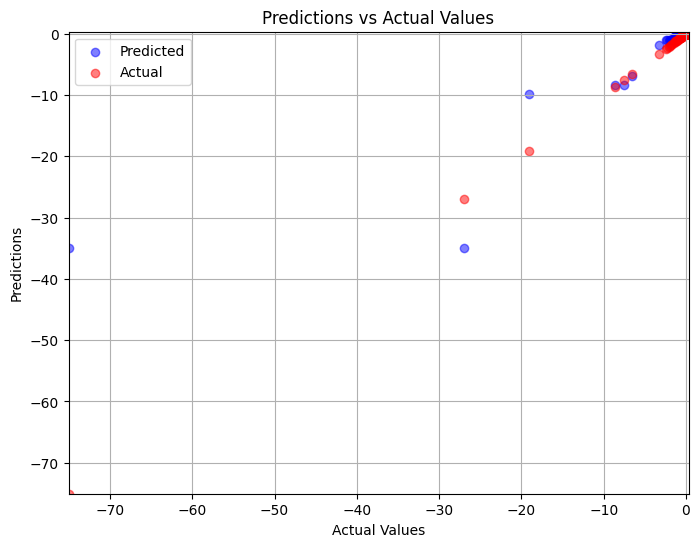

In [335]:
# Plot predictions versus actual values
plt.figure(figsize=(8, 6))
plt.scatter(valid_env_preds.target, valid_env_preds.preds, color='blue', alpha=0.5, label='Predicted')
plt.scatter(valid_env_preds.target, valid_env_preds.target, color='red', alpha=0.5, label='Actual')  # Actual values in red
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
# Set the limits of x-axis and y-axis to correspond to the full data range
xmin = min(np.min(valid_env_preds.target), np.min(valid_env_preds.preds))
xmax = max(np.max(valid_env_preds.target), np.min(valid_env_preds.preds))
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)

plt.legend()
plt.grid(True)
plt.show()

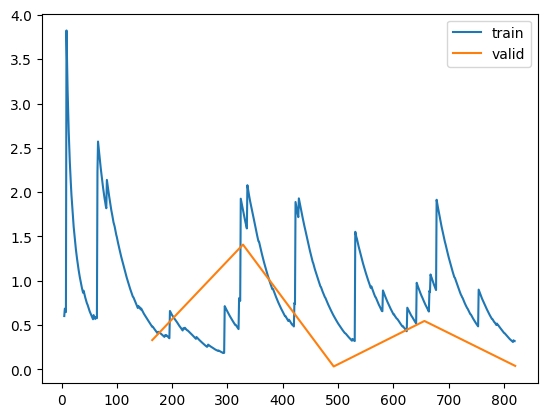

In [336]:
learn_env.recorder.plot_loss()

## FastAI

In [337]:
valid_corp_preds = pd.DataFrame({'target': valid_xs_corp.target, 'preds':validation_predictions_corp})
valid_corp_preds.head()

,target,preds
11399,0.060404,0.023265
4072,0.058228,0.023265
6134,0.059079,0.023265
2640,0.060212,0.023265
2505,0.059578,0.023265


### The test R2/RMSE

In [338]:
# Root mean squared error
rmse_score_corp = sklearn.metrics.r2_score(valid_corp_preds.preds, valid_corp_preds.target)
print("RMSE:", rmse_score_corp)

# mean squared error
mse_score_corp = sklearn.metrics.mean_squared_error(valid_corp_preds.preds, valid_corp_preds.target)
print("MSE:", mse_score_corp)

RMSE: 0.5818529148367949
MSE: 0.13378824106279685


### The training vs the validation loss 

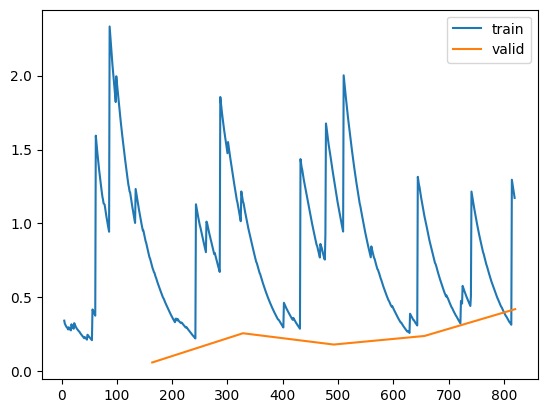

In [339]:
learn_corp.recorder.plot_loss()

### Visualizing the Prediction line vs. the Actual line 

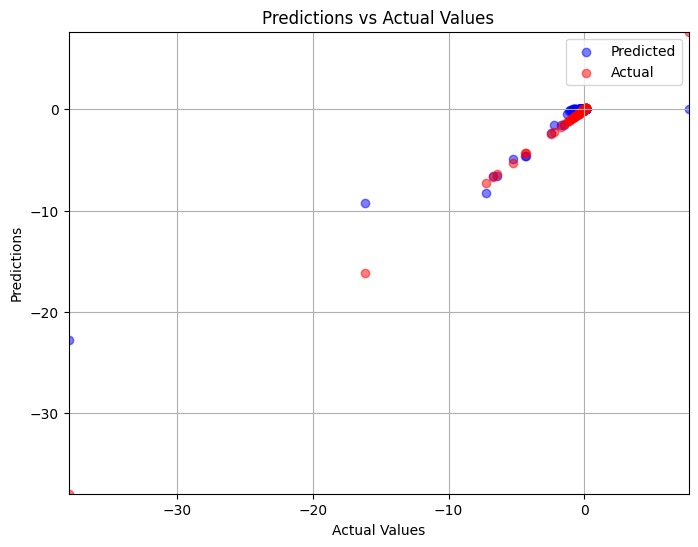

In [341]:
# Plot predictions versus actual values
plt.figure(figsize=(8, 6))
plt.scatter(valid_corp_preds['target'], valid_corp_preds['preds'], color='blue', alpha=0.5, label='Predicted')
plt.scatter(valid_corp_preds['target'], valid_corp_preds['target'], color='red', alpha=0.5, label='Actual')  # Actual values in red
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
# Set the limits of x-axis and y-axis to correspond to the full data range
xmin = min(np.min(valid_corp_preds['target']), np.min(valid_corp_preds['preds']))
xmax = max(np.max(valid_corp_preds['target']), np.min(valid_corp_preds['preds']))
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)

plt.legend()
plt.grid(True)
plt.show()

# Conclusion
As seen in the visualization of the r2 loss on the training and validation set, and then finally the predictions of the fastAI regression model vs the actual target values on the test set, using the "fastai_corpsplit_features" dataset and the fastai tabular_learner model performed better than when using the "fastai_env_features" and the fastai tabular_learner model.

Improvements that were made to preprocessing:

1. Splitting the features into the median number of features for that tuple per column and then filling in the missing feature values with the mean in corp_split.
2. Adding the company_name into the corp_split dataset introducing a categorical feature for prediction of environmental cost.

Although the corp_env dataset did not have the split features, it also had the company_name as a categorical value introduced which improved the model as much (or more) than as splitting the features.

In [345]:
print("### Error for unsplit features ###")
print("RMSE:", rmse_score_env)

# mean squared error for unsplit features
print("MSE:", mse_score_env)

print("### Error for split features ###")
print("RMSE:", rmse_score_corp)

# mean squared error for split features
print("MSE:", mse_score_corp)

### Error for unsplit features ###
RMSE: 0.35307886149103773
MSE: 0.6755714818235175
### Error for split features ###
RMSE: 0.5818529148367949
MSE: 0.13378824106279685
